In [2]:
import sqlite3
import pandas as pd
import duckdb
import matplotlib.pyplot as plt

In [3]:
with open("./seeds/finops_test.sql", "r") as f:
    sql_script = f.read()

# Create or connect to a SQLite database
conn = sqlite3.connect("finops.db")
cursor = conn.cursor()

In [4]:
# Execute the SQL script
cursor.executescript(sql_script)
conn.commit()
conn.close()

In [5]:
# Connect to the SQLite DB created from your SQL script
conn = sqlite3.connect("finops.db")
# Load the entire table into a DataFrame
df = pd.read_sql_query("SELECT * FROM finops_test", conn)
conn.close()

In [6]:
df.head()

,LinkedAccountId,bill/PayerAccountId,lineItem/UsageStartDate,lineItem/UsageEndDate,lineItem/UsageAmount,lineItem/Operation,pricing/PricingModel,resourceTags/TagKeys,resourceTags/TagValues,product/Region,product/ServiceCode,product/InstanceType,amortized_cost,product/Description
0,account-001,payer-123,2024-01-01T00:00:00Z,2024-01-01T01:00:00Z,1.0078,RunInstances,OnDemand,Game,BoomBeach,us-east-1,AmazonEC2,m4.4xlarge,10.078000000000001,
1,account-001,payer-123,2024-01-01T00:00:00Z,2024-01-01T01:00:00Z,1.2,RunInstances,OnDemand,Game,BoomBeach,us-east-1,AmazonEC2,m4.4xlarge,12.0,
2,account-001,payer-123,2024-01-01T00:00:00Z,2024-01-01T01:00:00Z,0.6870999999999999,RunInstances,OnDemand,Game,BoomBeach,us-east-1,AmazonEC2,c5.8xlarge,6.8709999999999996,
3,account-001,payer-123,2024-01-01T00:00:00Z,2024-01-01T01:00:00Z,0.3753,RunInstances,OnDemand,Game,BoomBeach,us-east-1,AmazonEC2,m4.4xlarge,3.753,
4,account-001,payer-123,2024-01-01T00:00:00Z,2024-01-01T01:00:00Z,1.2812000000000001,RunInstances,OnDemand,Game,BoomBeach,us-east-1,AmazonEC2,c5.8xlarge,12.812000000000001,


In [7]:
con = duckdb.connect('supercell.duckdb')

In [8]:
con.execute("CREATE OR REPLACE TABLE supercell_usagelogs AS SELECT * FROM df")

In [15]:
# con.execute("select * from  supercell_usagelogs").fetchall()

In [10]:
query = """
select * from total_cost ;
"""

df = con.execute(query).fetchdf()
print(df)

         month          region   instance_type      pricing_model  \
0   2024-01-01       us-east-1      m4.4xlarge           OnDemand   
1   2024-01-01    eu-central-1      m4.4xlarge           OnDemand   
2   2024-02-01       us-east-1     c7g.8xlarge       Savings Plan   
3   2024-02-01    eu-central-1      c5.8xlarge           OnDemand   
4   2024-04-01       us-west-1     m6i.4xlarge       Savings Plan   
..         ...             ...             ...                ...   
150 2024-07-01  ap-southeast-1      c5.8xlarge           OnDemand   
151 2024-08-01  ap-southeast-1      m4.4xlarge           OnDemand   
152 2024-08-01       us-east-1     m6i.4xlarge       Savings Plan   
153 2024-07-01                   db.r5.4xlarge           OnDemand   
154 2024-08-01  ap-southeast-1  db.r7g.4xlarge  Reserved Instance   

    service_code tag_values  total_cost  
0      AmazonEC2  BoomBeach   24265.330  
1      AmazonEC2  BoomBeach    3520.314  
2      AmazonEC2  ClashMini   47596.666  
3  

## Insights charts from the cubes

## What is total cost trend ?

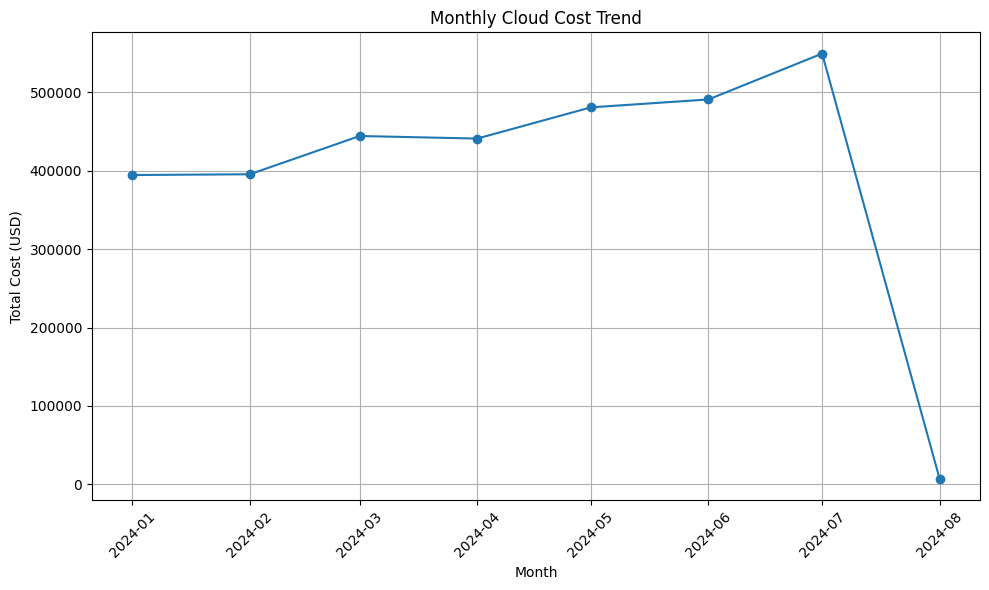

In [11]:

## What is total cost trend ?
query = """
    SELECT
        month,
        SUM(total_cost) AS monthly_cost
    FROM total_cost
    GROUP BY 1
    ORDER BY 1
"""

# Load into a DataFrame
df = con.execute(query).fetchdf()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['month'], df['monthly_cost'], marker='o')
plt.title('Monthly Cloud Cost Trend')
plt.xlabel('Month')
plt.ylabel('Total Cost (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## What is total cost trend ,by region by month ?

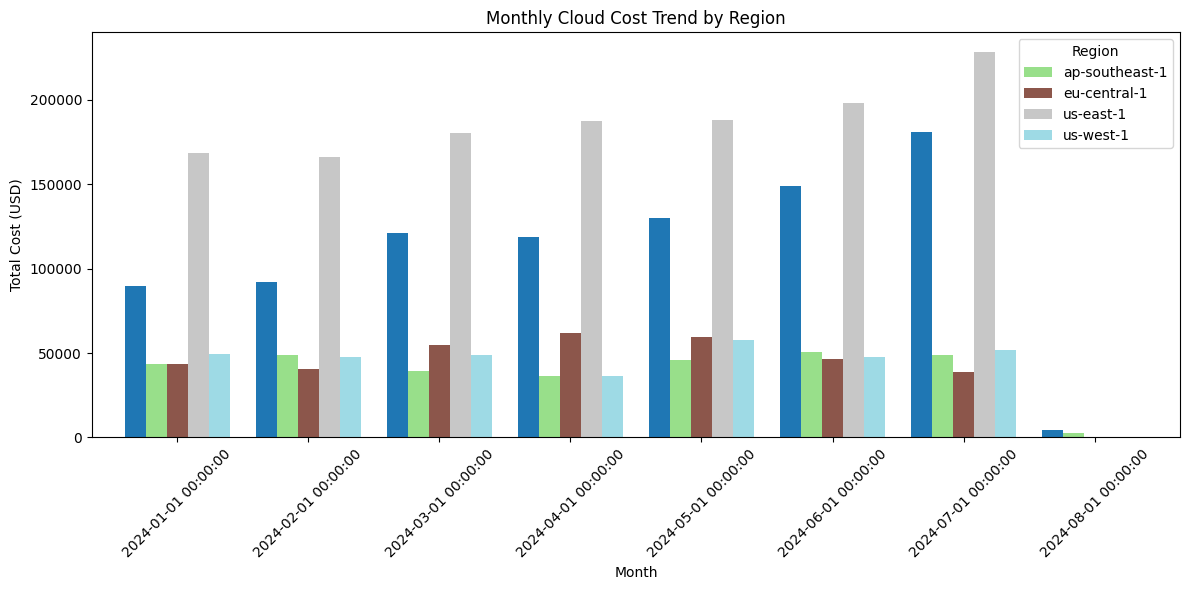

In [12]:

## What is total cost trend ,by region by month ?
query = """
    SELECT
        month,
        region,
        SUM(total_cost) AS monthly_cost
    FROM total_cost
    GROUP BY 1,2
    ORDER BY 1,2
"""

# Load into a DataFrame
df = con.execute(query).fetchdf()

# Pivot the DataFrame: rows = month, columns = region
pivot_df = df.pivot(index='month', columns='region', values='monthly_cost').fillna(0)

# Plot grouped bar chart
pivot_df.plot(
    kind='bar',
    figsize=(12, 6),
    width=0.8,
    colormap='tab20'
)

plt.title('Monthly Cloud Cost Trend by Region')
plt.xlabel('Month')
plt.ylabel('Total Cost (USD)')
plt.xticks(rotation=45)
plt.legend(title='Region')
plt.tight_layout()
plt.show()

## What is total cost trend ,by pricing model by month ?

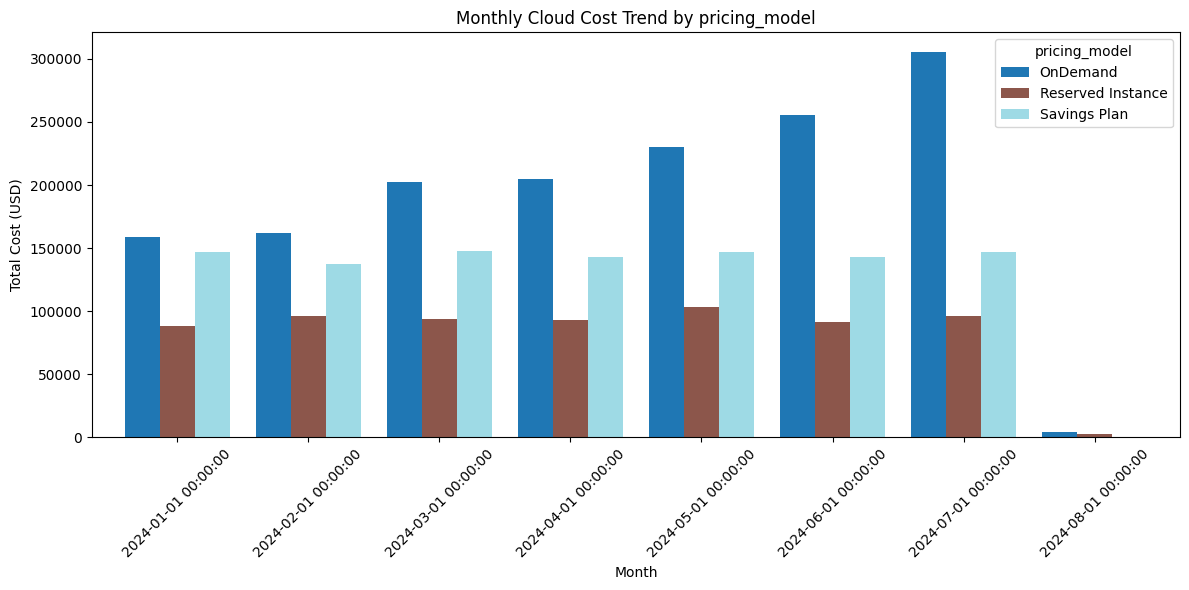

In [13]:

## What is total cost trend ,by pricing model by month ?
query = """
    SELECT
        month,
        pricing_model,
        SUM(total_cost) AS monthly_cost
    FROM total_cost
    GROUP BY 1,2
    ORDER BY 1,2
"""

# Load into a DataFrame
df = con.execute(query).fetchdf()

# Pivot the DataFrame: rows = month, columns = region
pivot_df = df.pivot(index='month', columns='pricing_model', values='monthly_cost').fillna(0)

# Plot grouped bar chart
pivot_df.plot(
    kind='bar',
    figsize=(12, 6),
    width=0.8,
    colormap='tab20'
)

plt.title('Monthly Cloud Cost Trend by pricing_model')
plt.xlabel('Month')
plt.ylabel('Total Cost (USD)')
plt.xticks(rotation=45)
plt.legend(title='pricing_model')
plt.tight_layout()
plt.show()

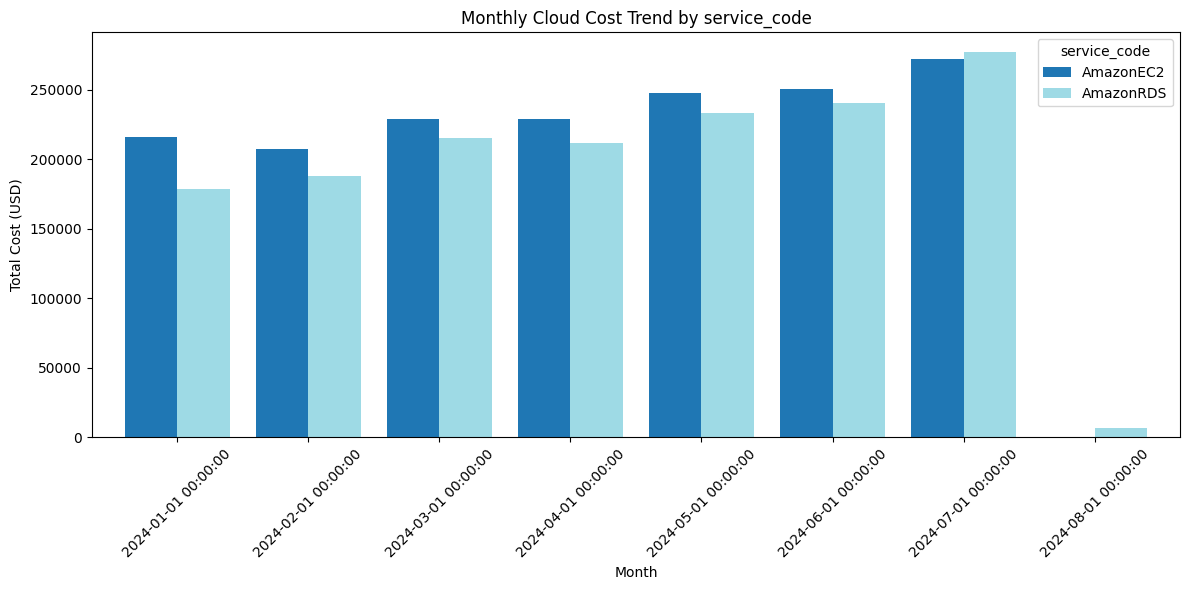

In [14]:

## What is total cost trend ,by service_code by month ?
query = """
    SELECT
        month,
        service_code,
        SUM(total_cost) AS monthly_cost
    FROM total_cost
    GROUP BY 1,2
    ORDER BY 1,2
"""

# Load into a DataFrame
df = con.execute(query).fetchdf()


# Load into a DataFrame
df = con.execute(query).fetchdf()

# Pivot the DataFrame: rows = month, columns = region
pivot_df = df.pivot(index='month', columns='service_code', values='monthly_cost').fillna(0)

# Plot grouped bar chart
pivot_df.plot(
    kind='bar',
    figsize=(12, 6),
    width=0.8,
    colormap='tab20'
)

plt.title('Monthly Cloud Cost Trend by service_code')
plt.xlabel('Month')
plt.ylabel('Total Cost (USD)')
plt.xticks(rotation=45)
plt.legend(title='service_code')
plt.tight_layout()
plt.show()